# Distribution of calibration error estimates

## Introduction

This example is taken from the publication
"Calibration tests in multi-class classification: A unifying framework" by Widmann,
Lindsten, and Zachariah.

We estimate calibration errors of the model
$$
\begin{aligned}
   g(X) &\sim \textrm{Dir}(\alpha),\\
   Z &\sim \textrm{Ber}(\pi),\\
   Y \,|\, g(X) = \gamma, Z = 1 &\sim \textrm{Categorical}(\beta),\\
   Y \,|\, g(X) = \gamma, Z = 0 &\sim \textrm{Categorical}(\gamma),
\end{aligned}
$$
where $\alpha \in \mathbb{R}_{>0}^m$ determines the distribution of
predictions $g(X)$, $\pi > 0$ determines the degree of miscalibration, and
$\beta$ defines a fixed categorical distribution.

Here we consider only the choices $\alpha = (0.1, \ldots, 0.1)$, mimicking a
distribution after training that is pushed towards the edges of the
probability simplex, and $\beta = (1, 0, \ldots, 0)$.

In our experiments we sample 250 predictions from the Dirichlet distribution
$\textrm{Dir}(\alpha)$, and then we generate corresponding labels according to
the model stated above, for different choices of $\pi$ and number of classes $m$.

We evaluate the standard estimators of expected calibration error (ECE) based on a
uniform binning scheme and a data-dependent binning scheme, and the biased estimator of
the squared kernel calibration error (SKCE), the quadratic unbiased estimator of
the SKCE, and the linear unbiased estimator of the SKCE for a specific choice of
matrix-valued kernels.

The sampling procedure and the evaluation are repeated 100 times, to obtain a sample
of 100 estimates for each considered setting of $\pi$ and $m$.

For our choice of $\alpha$ and $\beta$, the analytical ECE with respect to the
total variation distance $\|.\|_{\mathrm{TV}}$ is
$$
\mathbb{E}[\|.\|_{\mathrm{TV}},g] = \frac{\pi(m-1)}{m}.
$$

## Setup

In [1]:
using CalibrationErrors
using Distances
using Distributions
using StatsBase

using LinearAlgebra
using Random

using Plots
gr(fmt = :png, dpi = 600)

Plots.GRBackend()

## Estimates

In [2]:
function estimates(rng::AbstractRNG, estimator, π::Real, m::Int)
    # check arguments
    m > 0 || throw(ArgumentError("number of classes must be positive"))
    zero(π) <= π <= one(π) ||
        throw(ArgumentError("probability π must be between 0 and 1"))

    # cache array for predictions, modified predictions, and labels
    predictions = Matrix{Float64}(undef, m, 250)
    labels = Vector{Int}(undef, 250)
    data = (predictions, labels)

    # define sampler of predictions
    sampler_predictions = sampler(Dirichlet(m, 0.1))

    # initialize estimates
    estimates = Vector{Float64}(undef, 100)

    # for each run
    @inbounds for i in eachindex(estimates)
        # sample predictions
        rand!(rng, sampler_predictions, predictions)

        # sample labels
        @inbounds for j in eachindex(labels)
            if rand(rng) < π
                labels[j] = 1
            else
                labels[j] = sample(rng, Weights(view(predictions, :, j), 1))
            end
        end

        # evaluate estimator
        estimates[i] = estimator isa CalibrationErrors.CalibrationErrorEstimator ?
            calibrationerror(estimator, data) : calibrationerror(estimator(data), data)
    end

    estimates
end

estimates (generic function with 1 method)

We use a helper function to run the experiment for all desired parameter settings.

In [3]:
struct EstimatesSet{E}
    estimator::E
    m::Vector{Int}
    π::Vector{Float64}
    estimates::Vector{Vector{Float64}}
end

function estimates(rng::AbstractRNG, estimator)
    # create arrays
    mvec = Vector{Int}(undef, 0)
    πvec = Vector{Float64}(undef, 0)
    estimatesvec = Vector{Vector{Float64}}(undef, 0)

    # for all combinations of m and π
    for m in (2, 10, 100), π in (0.0, 0.5, 1.0)
        # compute estimates
        push!(estimatesvec, estimates(Random.GLOBAL_RNG, estimator, π, m))

        # save m and π
        push!(mvec, m)
        push!(πvec, π)
    end

    EstimatesSet(estimator, mvec, πvec, estimatesvec)
end

estimates(estimator) = estimates(Random.GLOBAL_RNG, estimator)

estimates (generic function with 3 methods)

As mentioned above, we can calculate the analytic expected calibration error. For the squared
kernel calibration error, we take the mean of the estimates of the unbiased quadratic
estimator as approximation of the true value.

We provide simple histogram plots of our results. The mean value of the
estimates is indicated by a solid black vertical line and the analytic
calibration error is visualized as a dashed red line.

In [4]:
@recipe function f(set::EstimatesSet)
    # default settings
    layout := (3, 3)
    legend := false
    xlabel := "calibration estimate"
    ylabel := "# runs"
    size --> (1080, 960)
    seriestype := :histogram

    # add subplots
    for i in 1:length(set.estimates)
        # retrieve data
        m = set.m[i]
        π = set.π[i]
        estimates = set.estimates[i]

        # plot histogram of estimates
        @series begin
            subplot := i
            x := estimates
        end

        # indicate analytic calibration error for ECE
        if set.estimator isa ECE
            @series begin
                seriestype := :vline
                subplot := i
                linewidth := 2
                color := :red
                x := [π * (m - 1) / m]
            end
        end

        # indicate mean of estimates
        @series begin
            title := "$m classes, pi = $π"
            seriestype := :vline
            subplot := i
            linewidth := 2
            color := :black
            x := [mean(estimates)]
        end
    end
end

## Kernel choice

We use an identity matrix scaled with an exponential kernel as matrix-valued
kernel. The bandwidth of the exponential kernel is set according to the
median heuristic.

In [5]:
function kernel(data)
    # compute median TV distance
    predictions = data[1]
    γ = inv(median(pairwise(TotalVariation(), predictions, dims=2)))

    # create kernel
    UniformScalingKernel(ExponentialKernel(γ, TotalVariation()))
end

kernel (generic function with 1 method)

## Expected calibration error

### Uniform binning

We start by analyzing the expected calibration error (ECE).
For our estimation we use 10 bins of uniform width in each dimension.

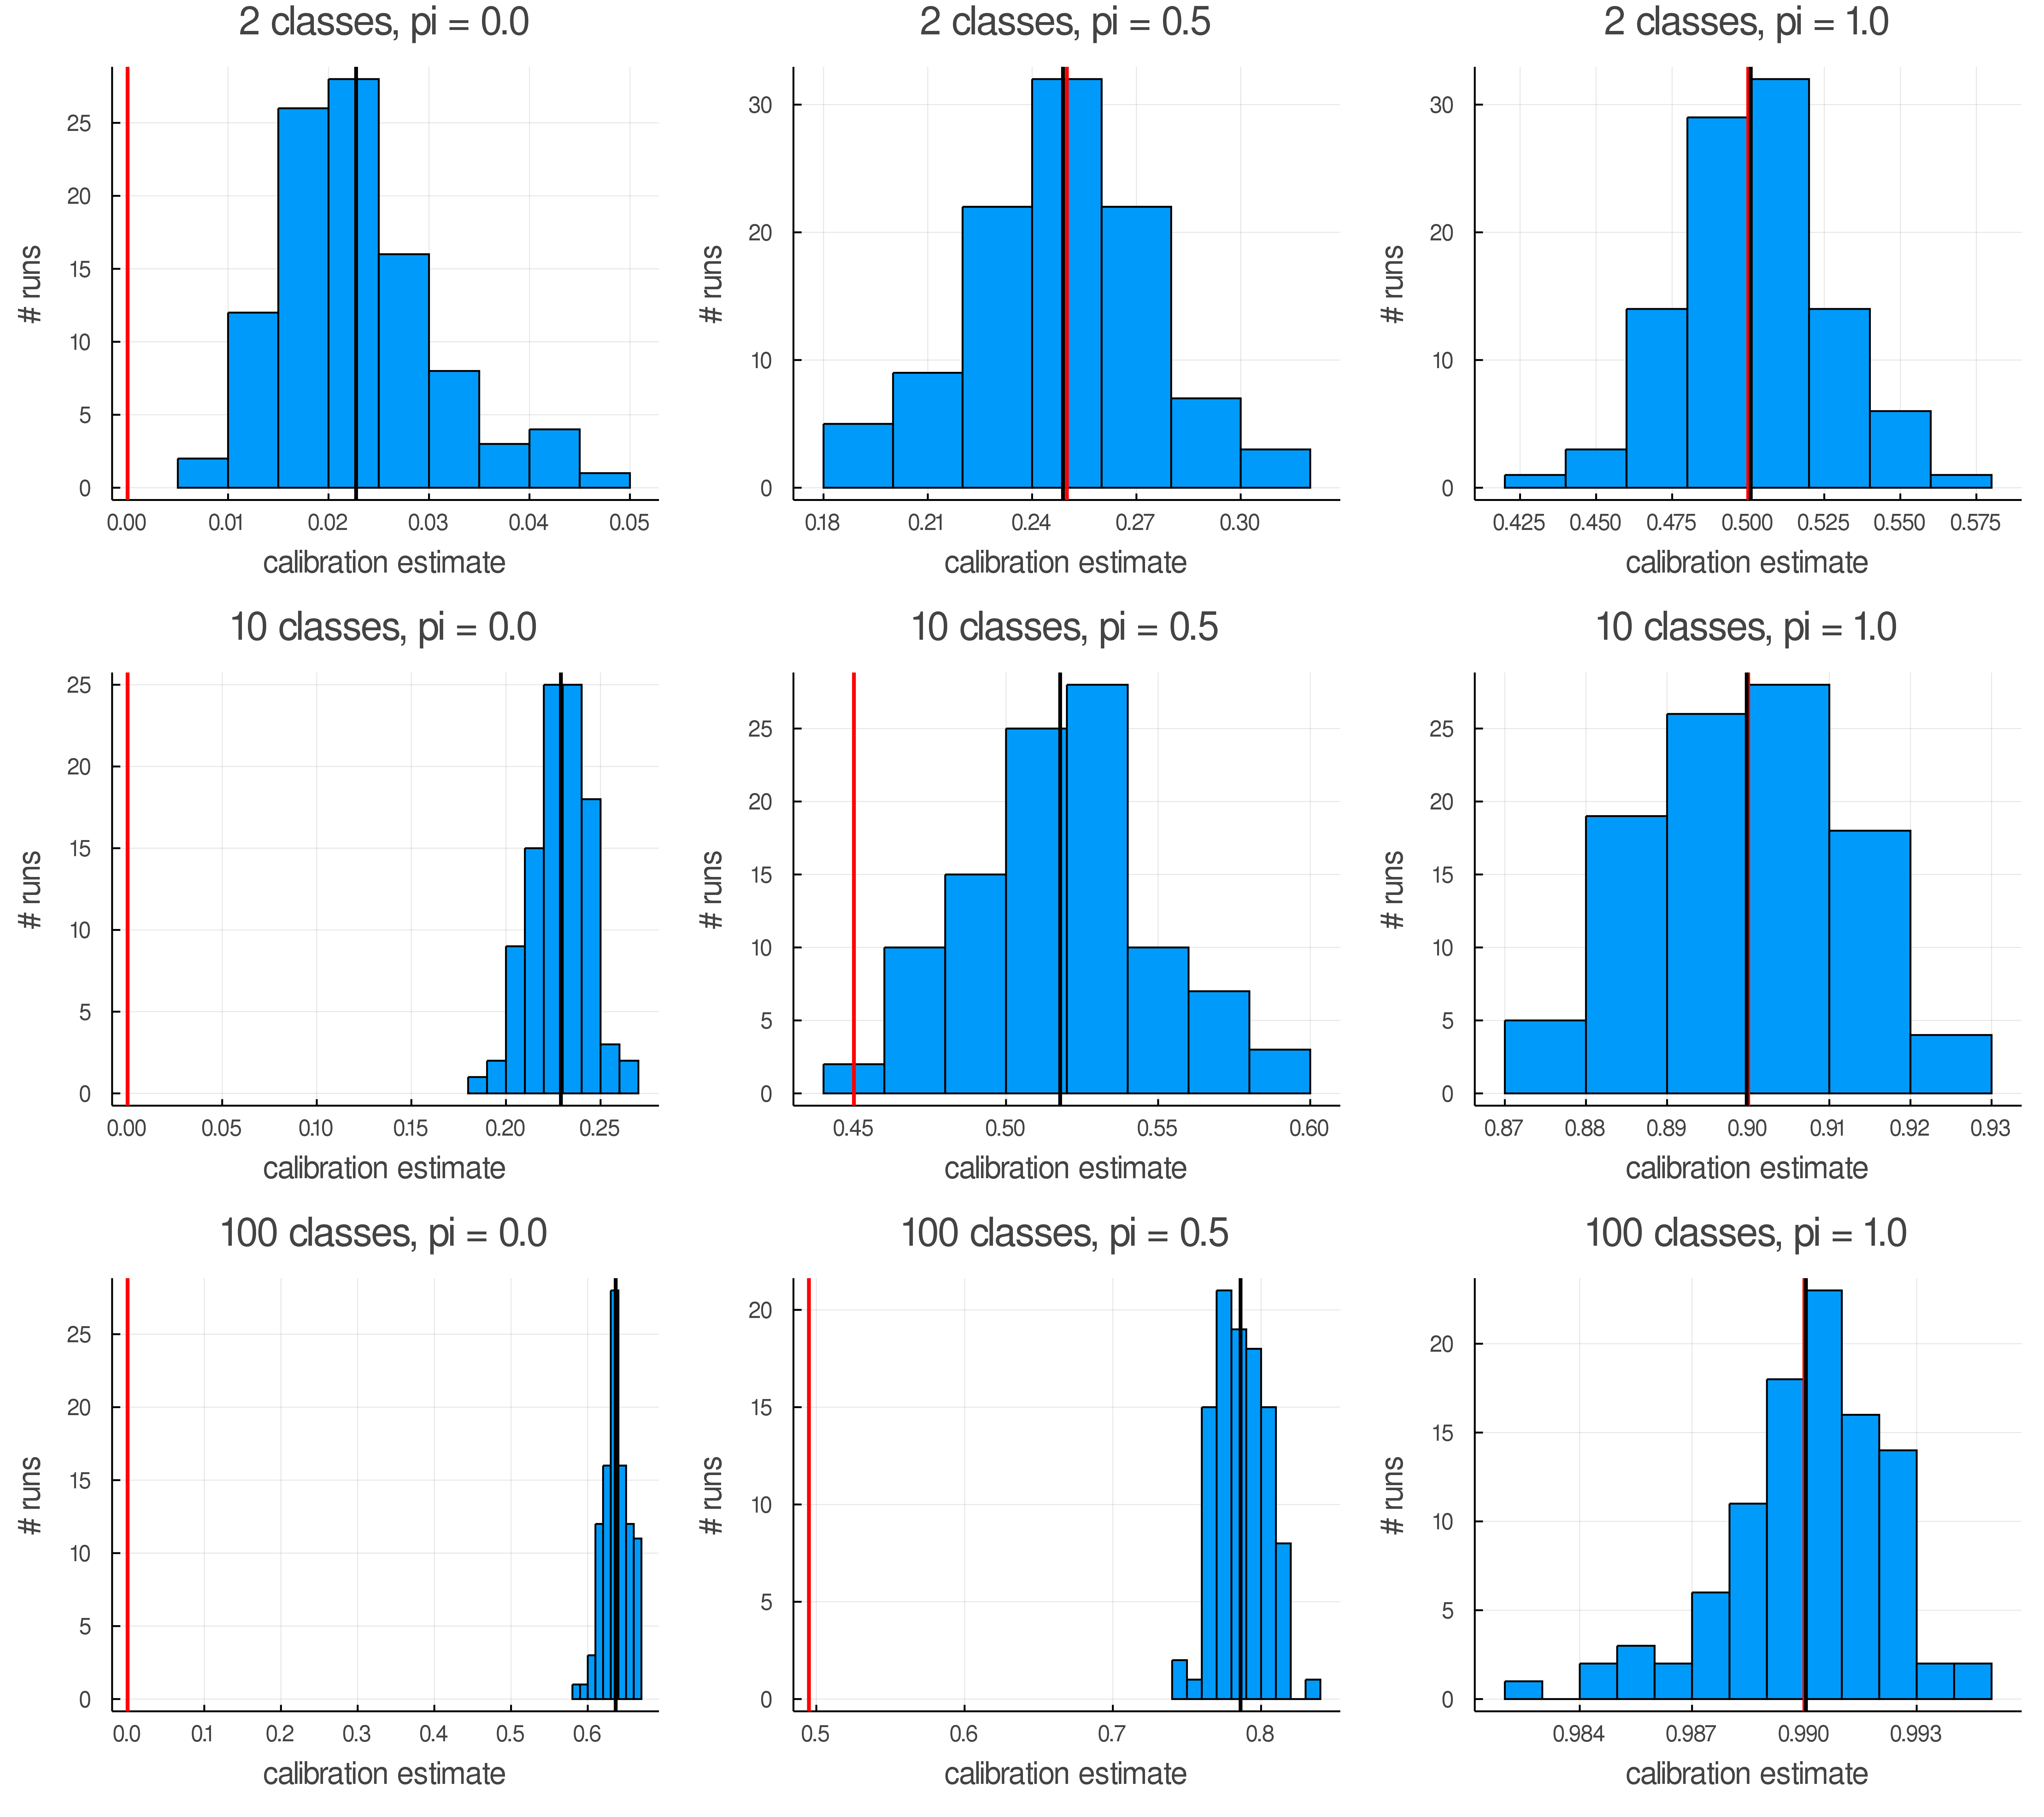

In [6]:
Random.seed!(1234)
data = estimates(ECE(UniformBinning(10), TotalVariation()))
plot(data)

### Non-uniform binning

We repeat our experiments with a different data-dependent binning scheme. This
time the bins will be computed dynamically by splitting the predictions at the
median of the classes with the highest variance, as long as the number of bins
does not exceed a given threshold and the number of samples per bin is above
a certain lower bound. In our experiments we do not impose any restriction on
the number of bins but only stop splitting if the number of samples is less
than 10.

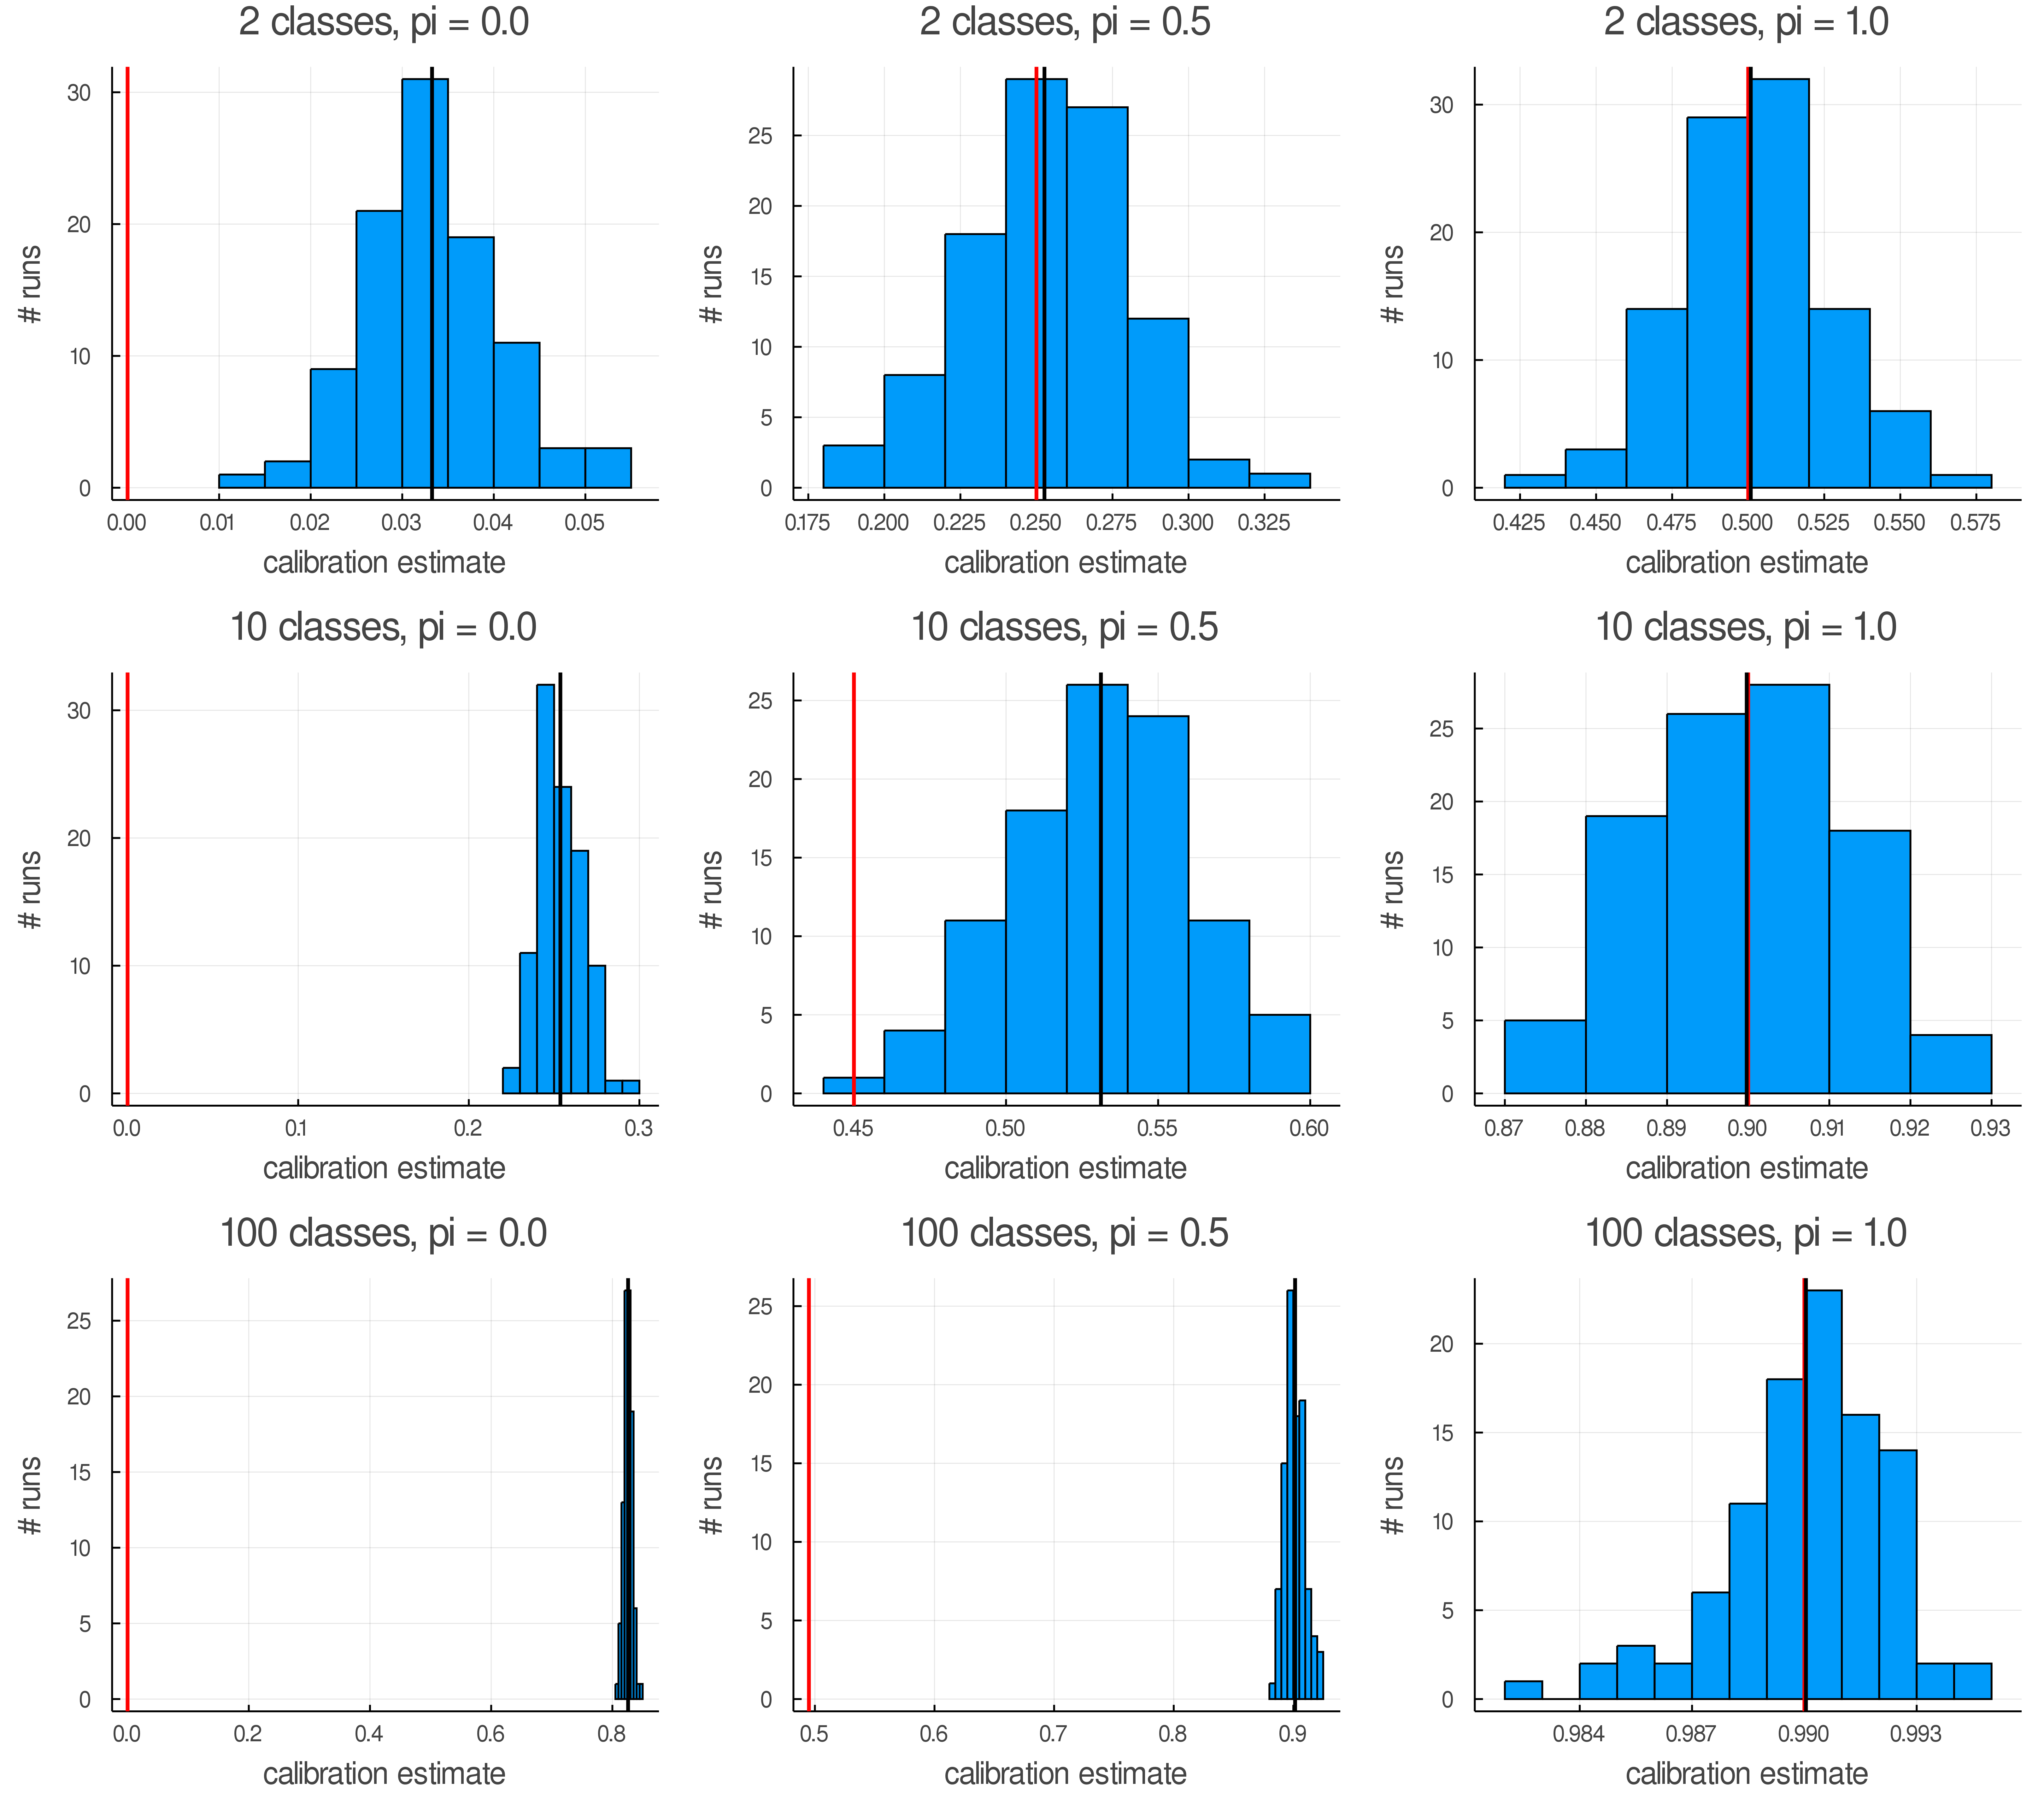

In [7]:
Random.seed!(1234)
data = estimates(ECE(MedianVarianceBinning(10), TotalVariation()))
plot(data)

## Biased estimator of the squared kernel calibration error

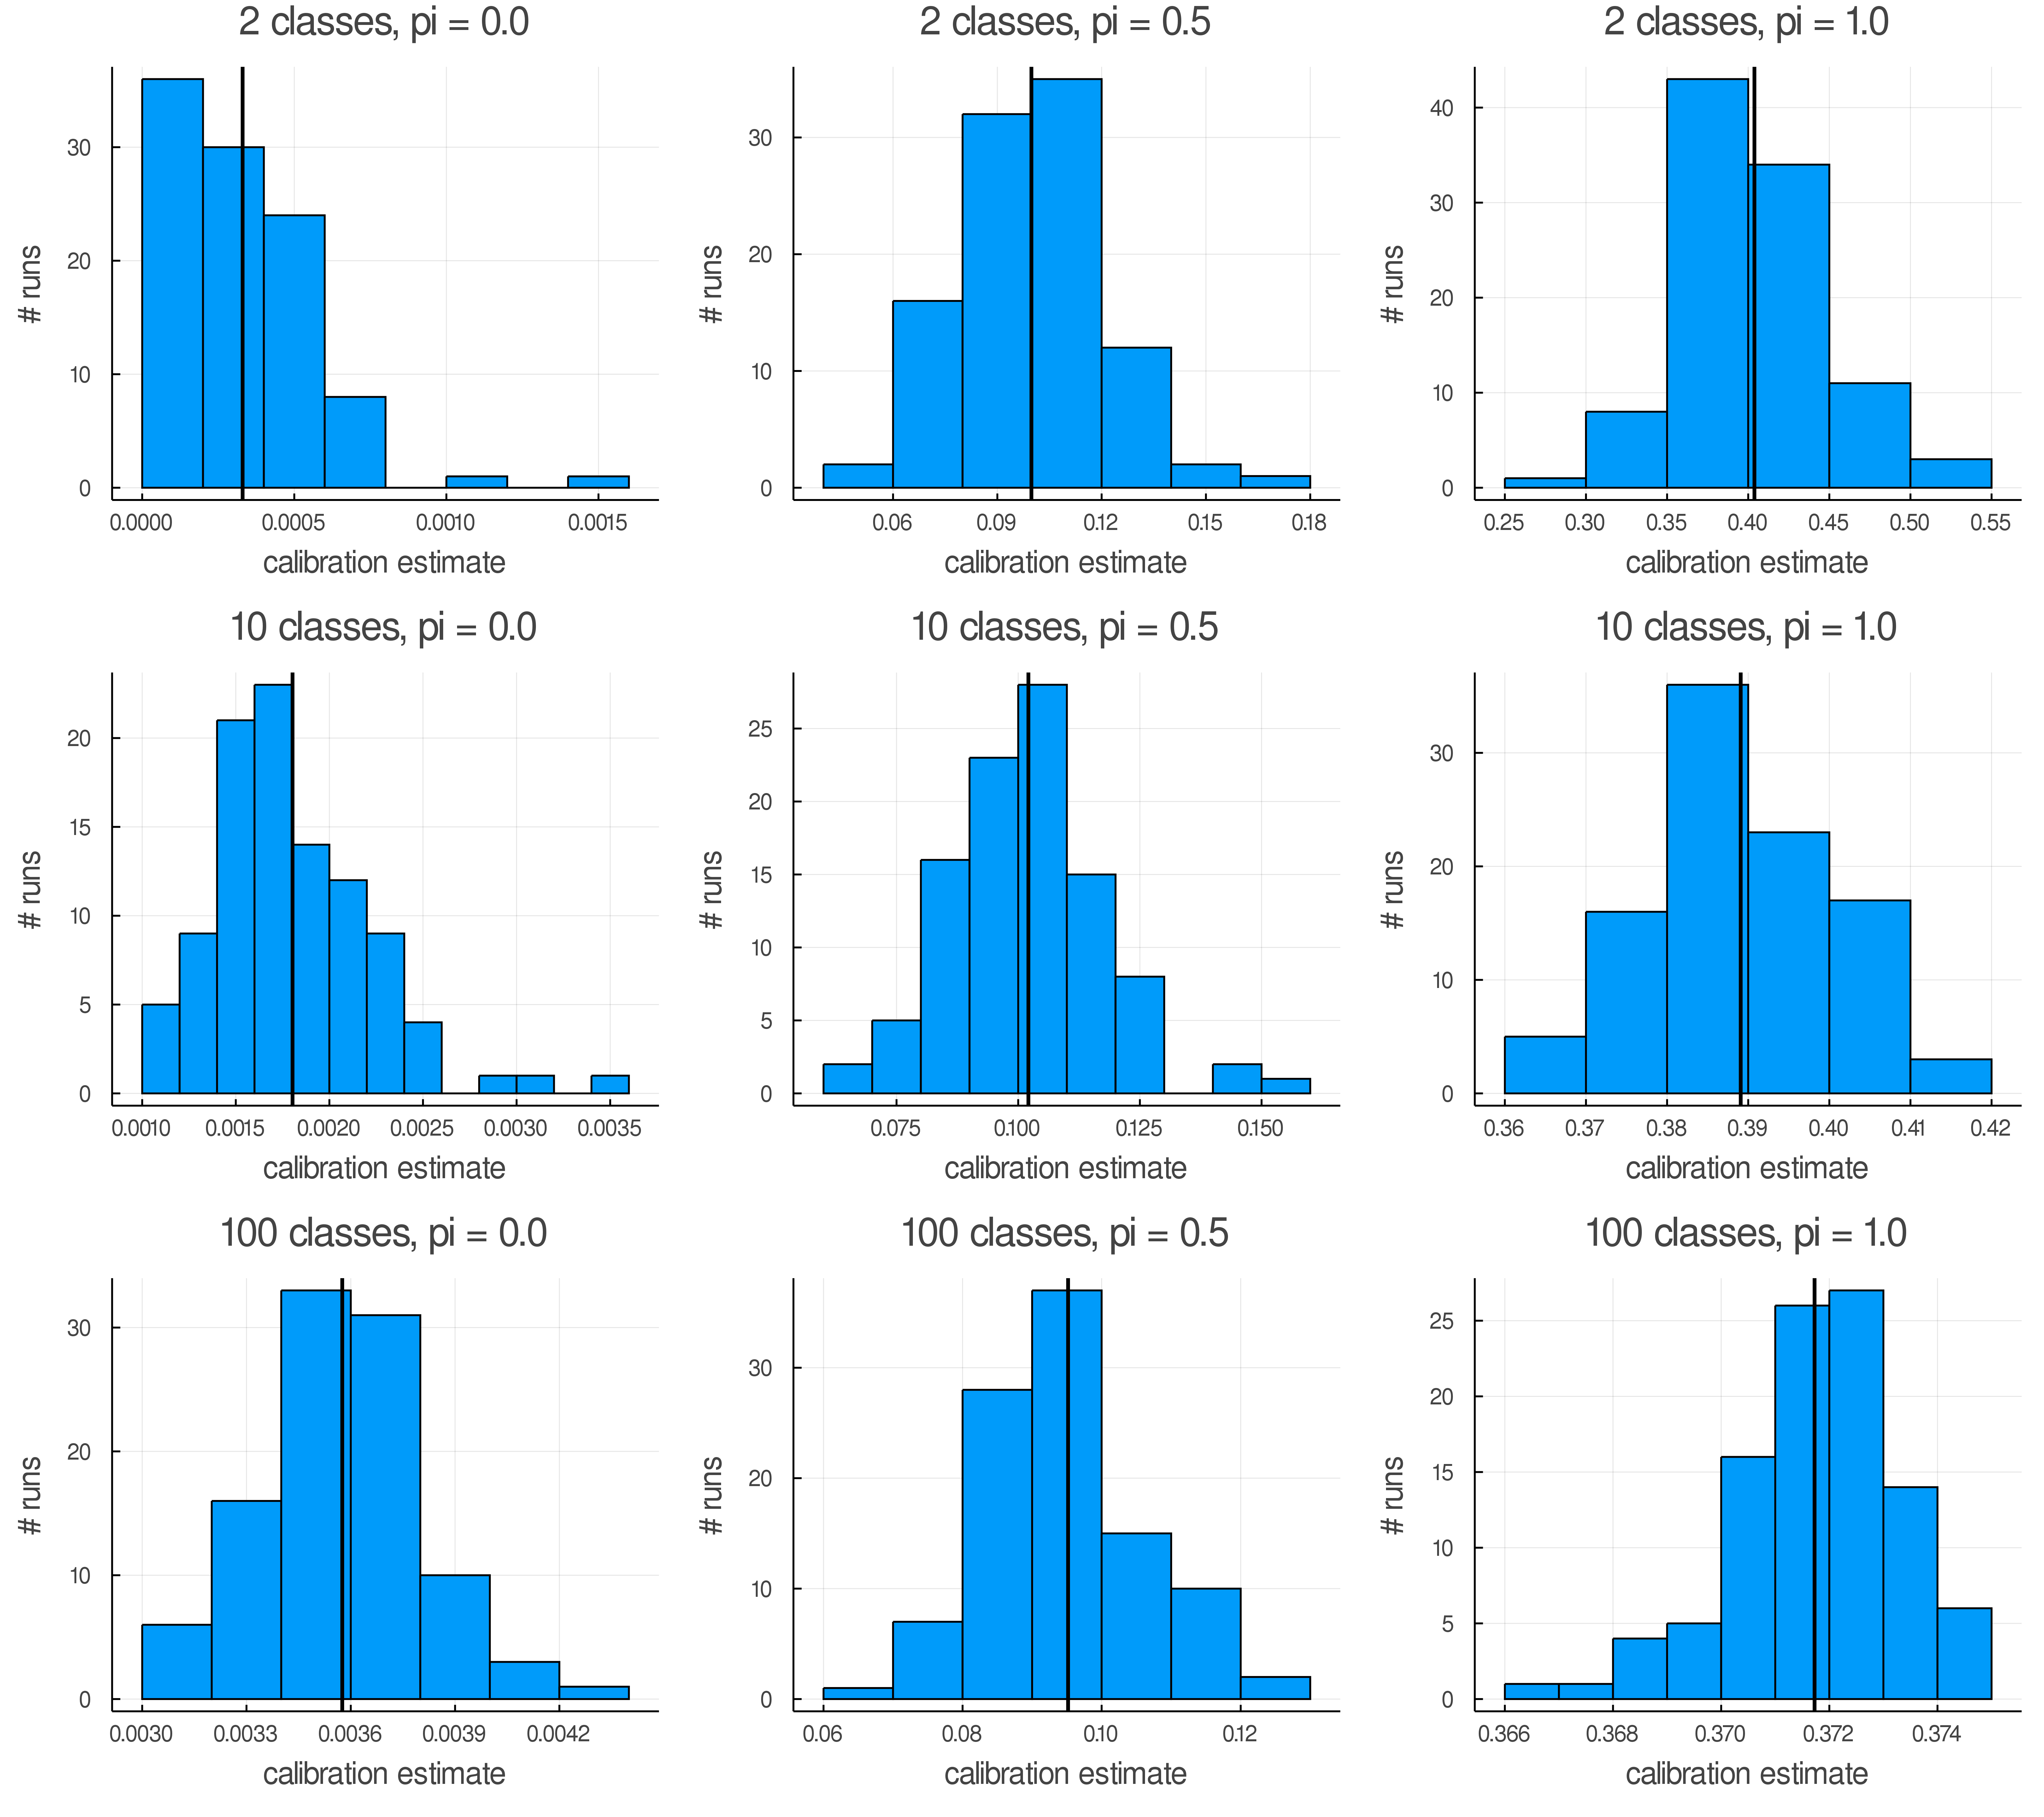

In [8]:
Random.seed!(1234)
data = estimates(x -> BiasedSKCE(kernel(x)))
plot(data)

## Unbiased quadratic estimator of the squared kernel calibration error

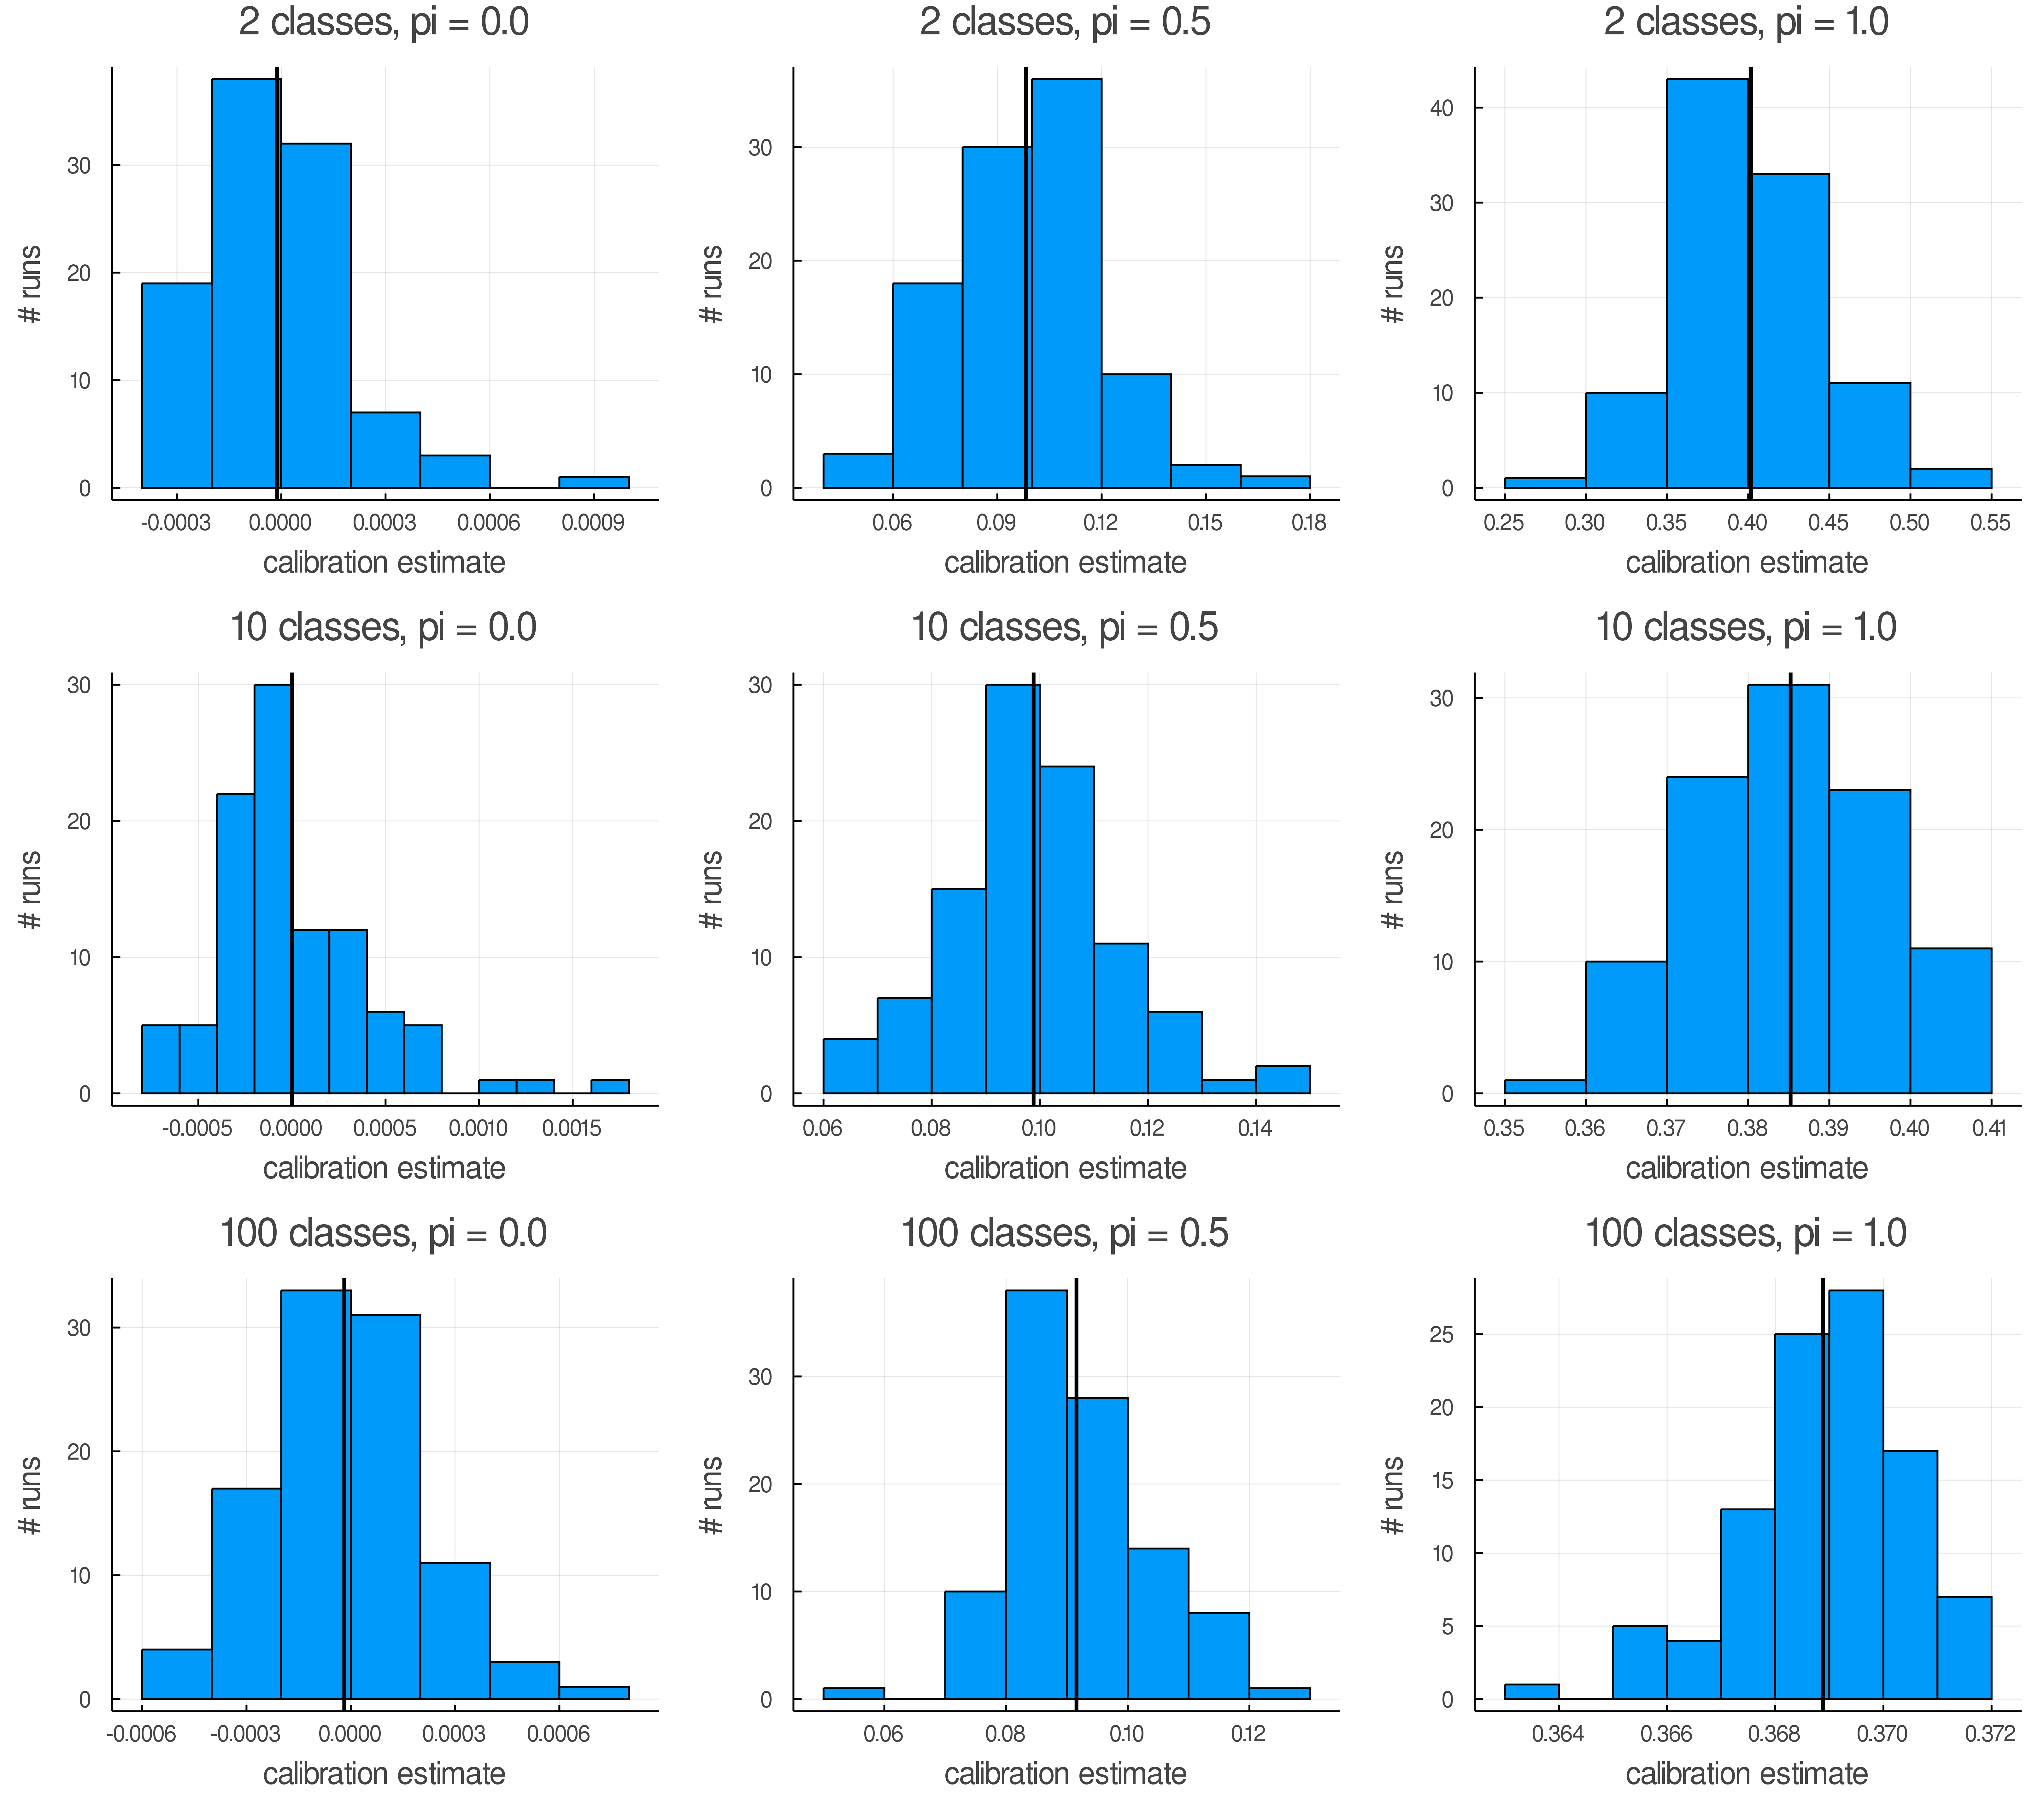

In [9]:
Random.seed!(1234)
data = estimates(x -> QuadraticUnbiasedSKCE(kernel(x)))
plot(data)

## Unbiased linear estimator of the squared kernel calibration error

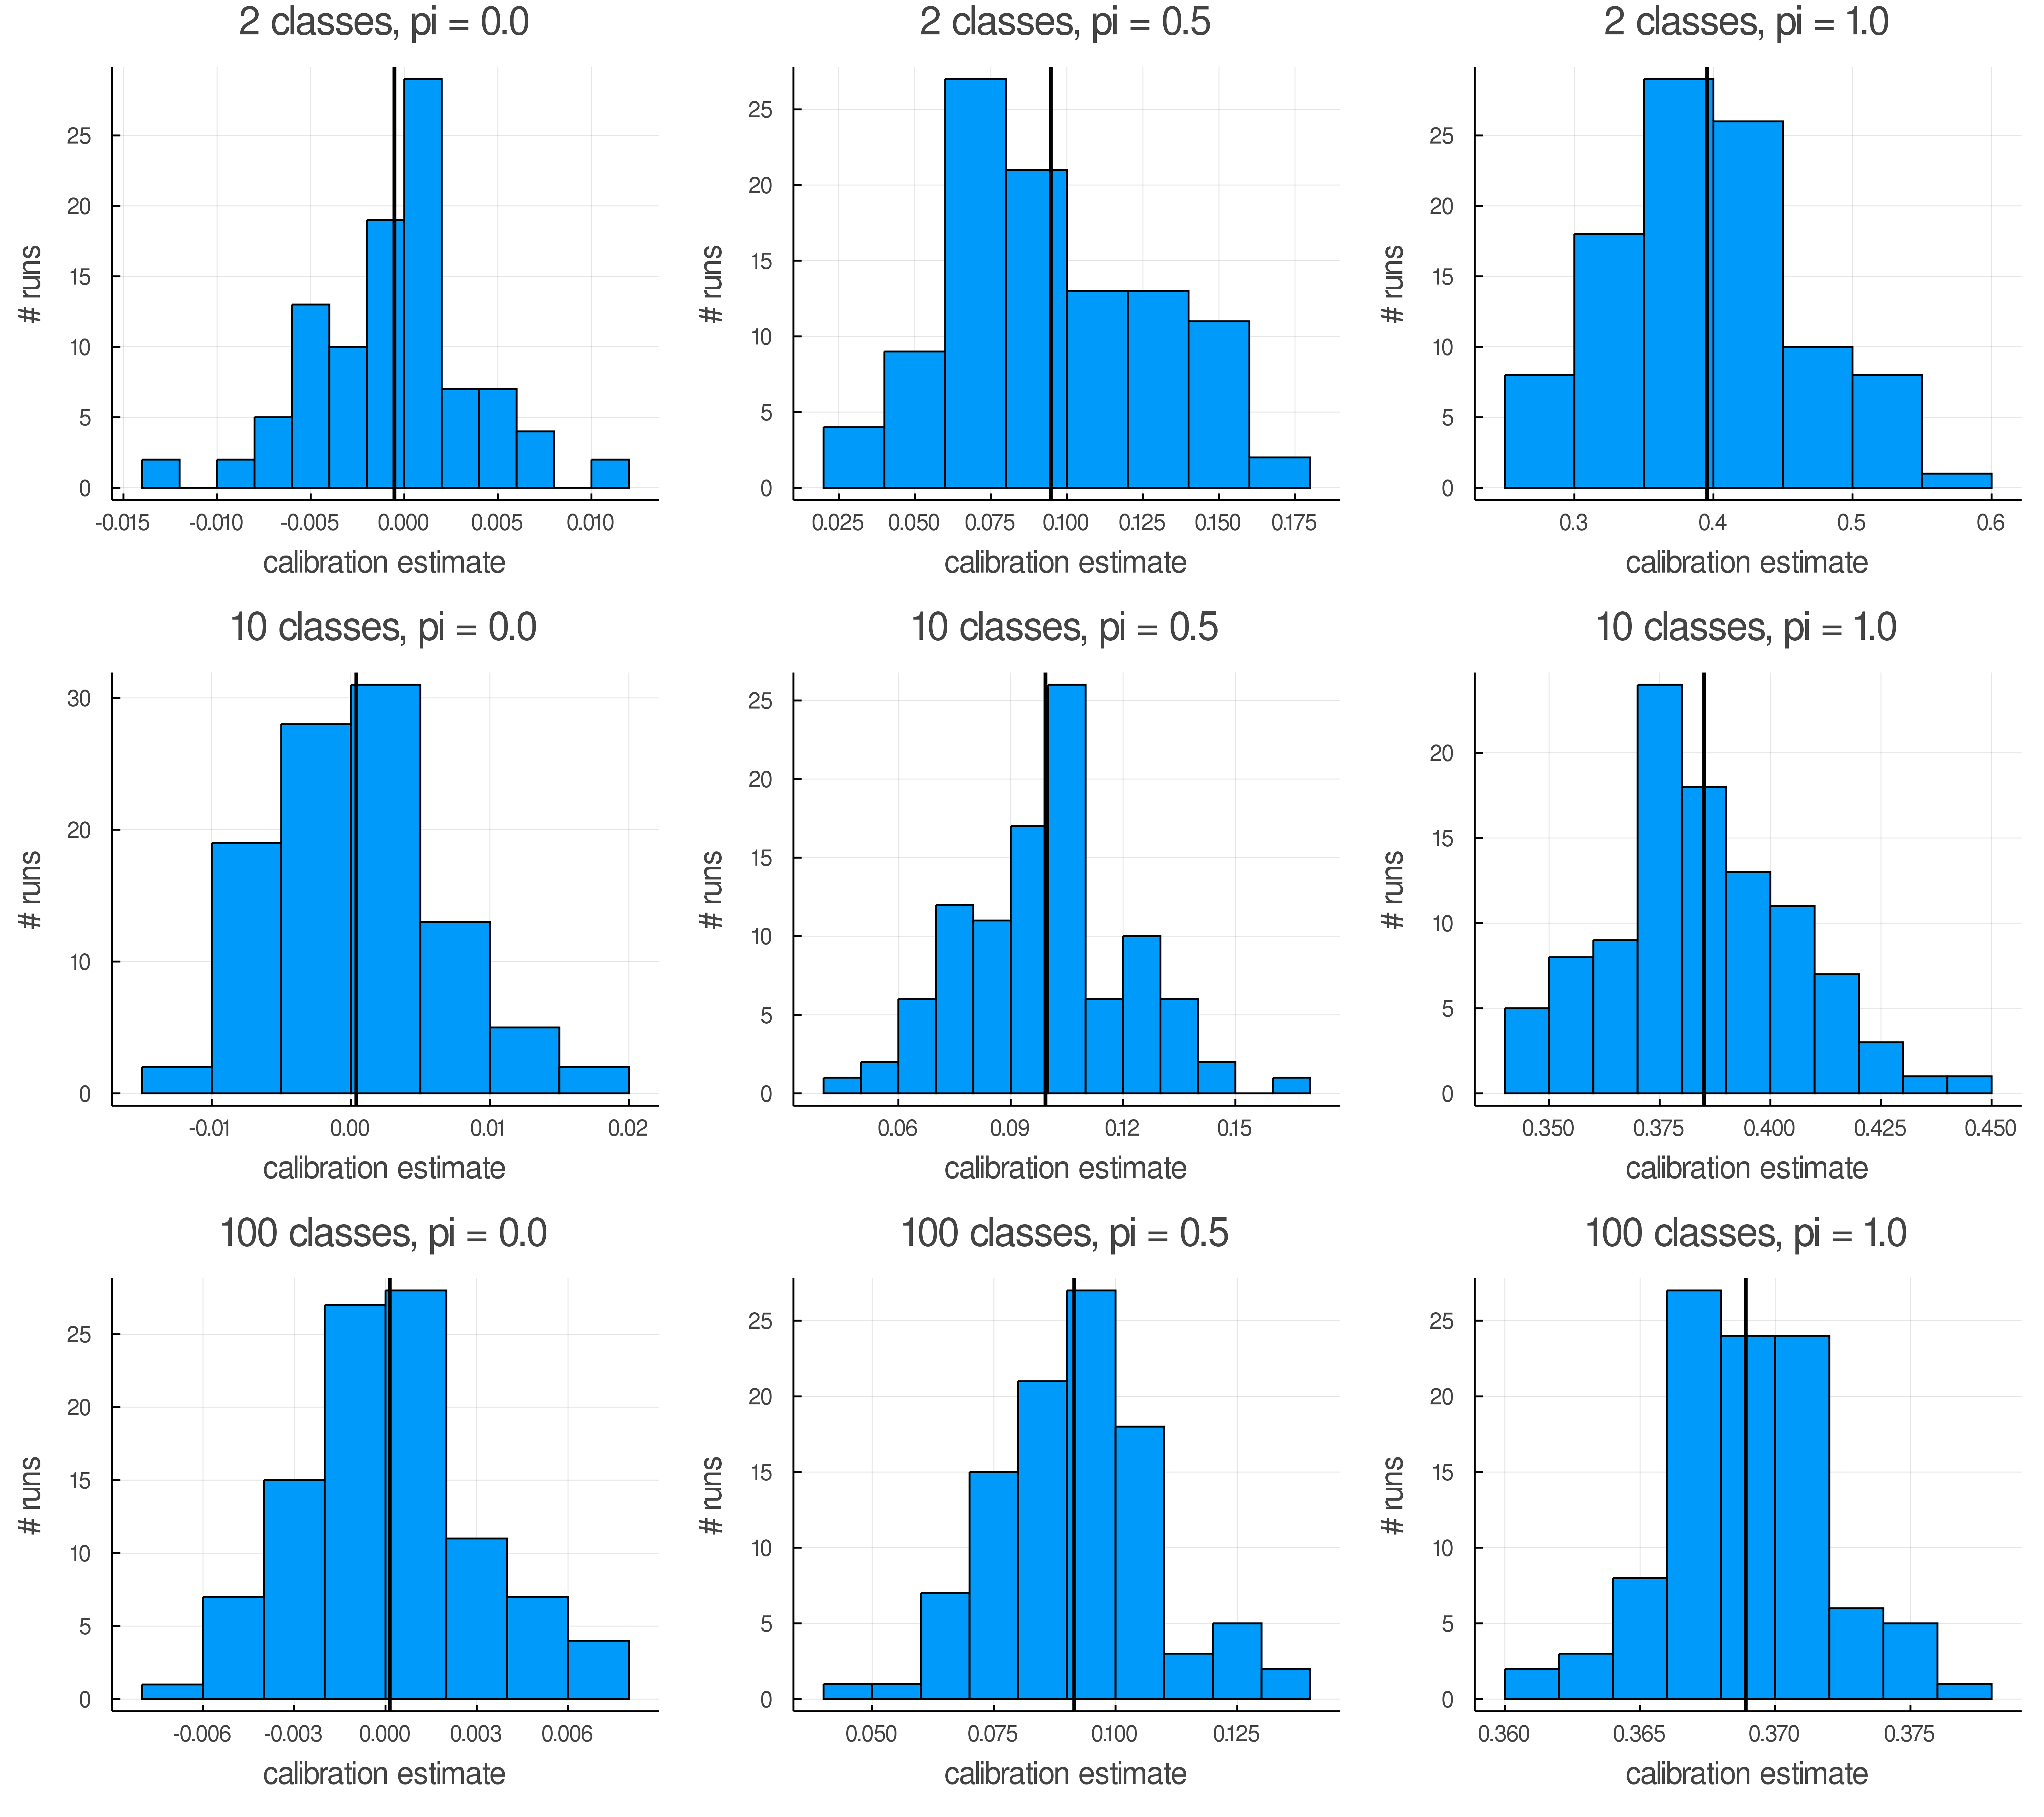

In [10]:
Random.seed!(1234)
data = estimates(x -> LinearUnbiasedSKCE(kernel(x)))
plot(data)

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*